# Business Problem 

# Data Cleaning

In [4]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob
import gensim
from gensim.models import Word2Vec


pd.set_option('display.max_columns', 1000)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
% matplotlib inline

import string, re

import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_csv('data/tweets.csv')

In [6]:
data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [7]:
data.isna().sum()

id             0
keyword        0
location    3418
text           0
target         0
dtype: int64

#  Exploratory Data Analysis

## Reclassifying Disaster as Event / Non-Event

In [8]:
data.head(20)

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
5,5,ablaze,OC,"If this child was Chinese, this tweet would ha...",0
6,6,ablaze,"London, England",Several houses have been set ablaze in Ngemsib...,1
7,7,ablaze,Bharat,Asansol: A BJP office in Salanpur village was ...,1
8,8,ablaze,"Accra, Ghana","National Security Minister, Kan Dapaah's side ...",0
9,9,ablaze,Searching,This creature who’s soul is no longer clarent ...,0


When going through the text data, we found that disaster is used incorrectly in classifying the tweets. We found that a better classification would more appropriately be either "Event" or "Non-Event." This is because we found many instances of positive "Disaster" classification when we believe the instance to not meet that definition. For example, many instances of thunderstorms were each classified as a "Disaster", while we believe that instances such as those would be better classified as an "Event."

## What should they search for?

### What's the Class Imbalance?

Text(0, 0.5, 'Percentage')

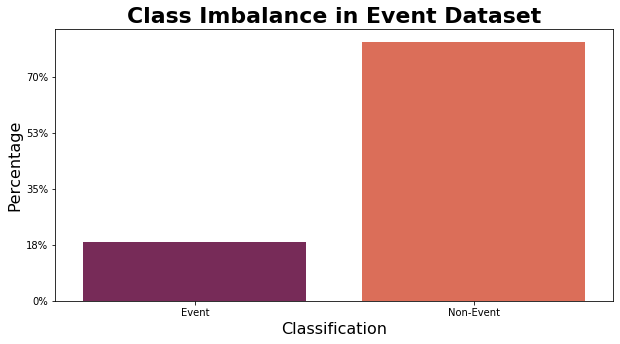

In [9]:
class_imbalance = [len(data[data.target == 1]), len(data[data.target == 0])]
classes = ['Event','Non-Event']

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(classes, class_imbalance, ax = ax, palette='rocket')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(11370))
plt.title('Class Imbalance in Event Dataset', fontsize=22, fontweight='bold')
plt.xlabel('Classification', fontsize=16)
plt.ylabel('Percentage', fontsize=16)

### Most Common Keywords that were Real Events

In [10]:
# data[data.target == 1]['keyword'].value_counts().head(10).plot(kind = 'bar')
keyword_real = pd.DataFrame(data[data.target == 1]['keyword'].value_counts().head(10))
keyword_real.reset_index(inplace=True)
keyword_real.columns = ['keyword','frequency']
keyword_real.keyword = keyword_real.keyword.apply(lambda x: x.split('%20'))
keyword_real.keyword = keyword_real.keyword.apply(lambda x: ','.join(x))
keyword_real.keyword = keyword_real.keyword.apply(lambda x: x.replace(',',' '))
keyword_real.keyword = keyword_real.keyword.apply(lambda x: x.title())


Text(0.5, 0, 'Frequency')

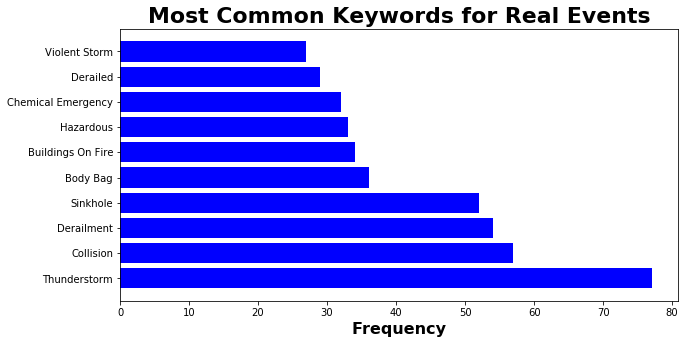

In [11]:
plt.figure(figsize=(10,5))
plt.barh(keyword_real.keyword, keyword_real.frequency, color='blue')
plt.title('Most Common Keywords for Real Events', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=16, fontweight='bold')

### Most Common Keywords that were Not Event Related

In [12]:
keyword_not = pd.DataFrame(data[data.target == 0]['keyword'].value_counts().head(10))
keyword_not.reset_index(inplace=True)
keyword_not.columns = ['keyword','frequency']
keyword_not.keyword = keyword_not.keyword.apply(lambda x: x.split('%20'))
keyword_not.keyword = keyword_not.keyword.apply(lambda x: ','.join(x))
keyword_not.keyword = keyword_not.keyword.apply(lambda x: x.replace(',',' '))
keyword_not.keyword = keyword_not.keyword.apply(lambda x: x.title())

Text(0.5, 0, 'Frequency')

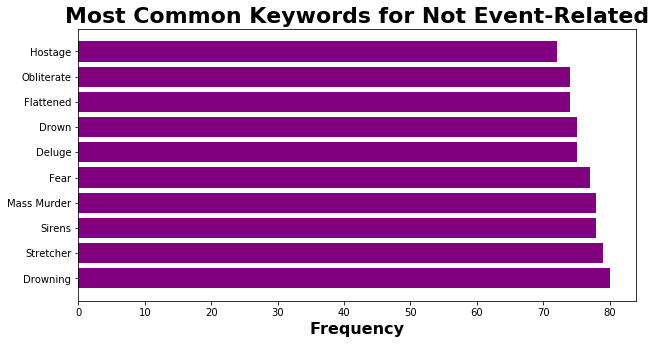

In [13]:
plt.figure(figsize=(10,5))
plt.barh(keyword_not.keyword, keyword_not.frequency, color='purple')
plt.title('Most Common Keywords for Not Event-Related', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=16, fontweight='bold')

### Where are our Tweets Coming From?

In [14]:
data.location.replace(['California, USA', 'Los Angeles, CA', 'United States'], 'USA', inplace= True)
data.location.replace(['Lagos, Nigeria'], 'Nigeria', inplace= True)
data.location.replace(['England, United Kingdom','United Kingdom'], 'UK', inplace= True)
data.location.replace(['Earth'], 'Unknown', inplace= True)


Text(0.5, 0, 'Frequency')

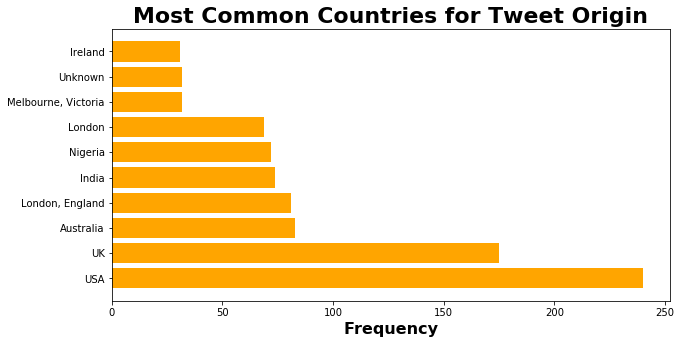

In [15]:
location = pd.DataFrame(data.location.value_counts().head(10))

plt.figure(figsize=(10,5))
plt.barh(location.index, location.location, color='orange')
plt.title('Most Common Countries for Tweet Origin', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=16, fontweight='bold')

### Was Sentiment Different Btw the Positive and Negative Classes?

#### Polarity

In [16]:
data['polarity_score'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [17]:
positive = data[data.target == 1]
negative = data[data.target == 0]
perc_pos = round((len(positive[positive.polarity_score < 0]) / len(positive)), 3)
perc_neg = round((len(negative[negative.polarity_score < 0]) / len(negative)), 3)
print('{}% of the disaster data has negative polarity'.format(perc_pos))
print('{}% of the non-disaster data has negative polarity'.format(perc_neg))

0.299% of the disaster data has negative polarity
0.225% of the non-disaster data has negative polarity


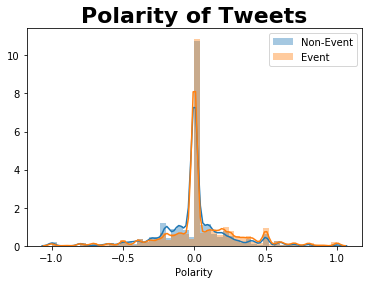

In [18]:
sns.distplot(positive.polarity_score, label='Non-Event')
sns.distplot(negative.polarity_score, label='Event')

plt.title('Polarity of Tweets', fontsize=22, fontweight='bold')
plt.xlabel('Polarity')
plt.legend()

#### Subjectivity

In [19]:
data['subjectivity_score'] = data['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

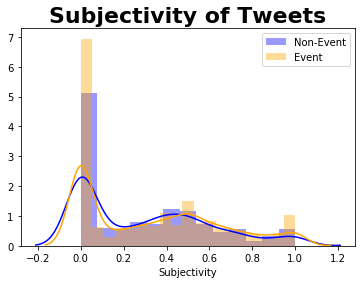

In [20]:
positive = data[data.target == 1]
negative = data[data.target == 0]
sns.distplot(positive.subjectivity_score, label='Non-Event', color='blue')
sns.distplot(negative.subjectivity_score, label='Event', color='orange')

plt.title('Subjectivity of Tweets', fontsize=22, fontweight='bold')
plt.xlabel('Subjectivity')
plt.legend()

### Does Tweet Length Make a Difference?

In [21]:
data['text_length'] = data['text'].apply(lambda x: len(x))

In [22]:
positive = data[data.target == 1]
negative = data[data.target == 0]

Text(0, 0.5, 'Median')

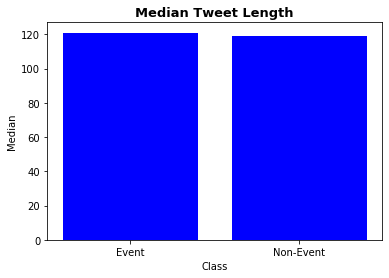

In [23]:
avg_length_pos = positive.text_length.median()
avg_length_neg = negative.text_length.median()
plt.bar(('Event','Non-Event'),(avg_length_pos, avg_length_neg), color='blue')
plt.title('Median Tweet Length', fontsize=13, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Median')

### Is there a Difference Btw Tweets with and without Hyperlinks?

In [24]:
data['hyperlink_present'] = data.text.apply(lambda x: 1 if 'https' in x else 0)

In [25]:
positive = data[data.target == 1]
negative = data[data.target == 0]

Text(0, 0.5, 'Hyperlink in Tweet Rate')

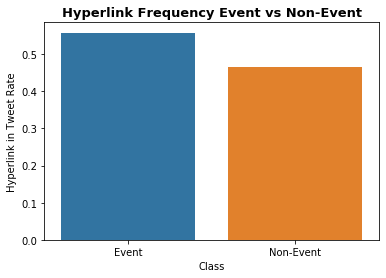

In [26]:
hyperlink_labels = ['Event','Non-Event']
hyperlink_frequencies = ((positive.hyperlink_present.sum() / len(positive)), 
                     (negative.hyperlink_present.sum() / len(negative)))

sns.barplot(hyperlink_labels, hyperlink_frequencies)
plt.title('Hyperlink Frequency Event vs Non-Event', fontsize=13, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Hyperlink in Tweet Rate')

### Most Common Unigram Search Result Words for Real Events

In [27]:
cloud = data
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
cloud.text = cloud.text.apply(lambda x: tokenizer.tokenize(x))

In [28]:
def lower_token(word_list):
    lowered_tokenized = []
    for x in word_list:
        x = x.lower()
        lowered_tokenized.append(x)
    return lowered_tokenized

cloud.text = cloud.text.apply(lambda x: lower_token(x))

In [29]:
stopword_given = stopwords.words('english')
more_stopwords = ['co','amp','say','want','really','many','let','see','said','got','day','https','c','w','still','go','u','new','one','b','know','two','make','people','us','think','h','time','g','another','p','l','today','th','n','e','v','x','j','z','f','always','good','thing','must','someone','even','much','guy','work','house','video','every','stop','remember','need','first','back','country','well','man','come','live','year','via','take','going','tell','next','q','place','says','days','made','news','world','hour','feel','bad','last','never','put','may','way','gon','na','au','gove']
stopwords_final = stopword_given + more_stopwords

In [30]:
def remove_stops(word_list):
    filtered = []
    for x in word_list:
        if x not in stopwords_final:
            filtered.append(x)
    return filtered

cloud.text = cloud.text.apply(lambda x: remove_stops(x))

In [31]:
cloud.text = cloud.text.apply(lambda x: ','.join(x))
cloud.text = cloud.text.apply(lambda x: x.replace(',',' '))

In [32]:
cloud_positive = cloud[cloud.target == 1]
text_positive = " ".join(review for review in cloud_positive.text)

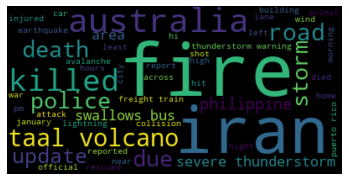

In [33]:
wordcloud_full = WordCloud(background_color="black", max_words = 50).generate(text_positive)

plt.imshow(wordcloud_full, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most Common Unigram Search Result Words for Non Event-Related

In [34]:
cloud_negative = cloud[cloud.target == 0]

In [35]:
text_negative = " ".join(review for review in cloud_negative.text)

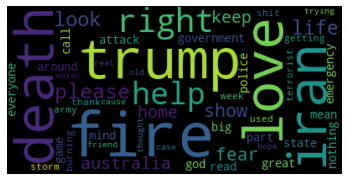

In [36]:
wordcloud_negative = WordCloud(background_color="black", max_words = 50).generate(text_negative)

plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most Common Unigram Search Result Words for Real Events

In [37]:
def wordcloud_creator_bigram(data, max_words = 50, stopwords=None):

    # Tokenize data
    nltk_tokens = nltk.word_tokenize(data)
    tokens_minus_stop = []
    for i in nltk_tokens:
        if i not in stopwords_final:
            tokens_minus_stop.append(i)
    # Create bigrams
    bigrams_list = list(nltk.bigrams(tokens_minus_stop))
    # Join bigrams
    bigrams = [' '.join(tup) for tup in bigrams_list]
    # Fit transform bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(bigrams)
    # Get bigram counts
    sum_words = bag_of_words.sum(axis=0) 
    # Create fequency dictionary
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    # Sort frequency dictionary
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Reformat as dictionary
    words_dict = dict(words_freq)
    
    # Create wordcloud
    wordcloud = WordCloud(max_words=max_words, stopwords=None)
    wordcloud.generate_from_frequencies(words_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    return plt.show()

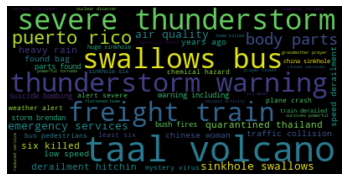

In [38]:
wordcloud_creator_bigram(text_positive)

### Most Common Bigram Search Result Words for Non Event-Related

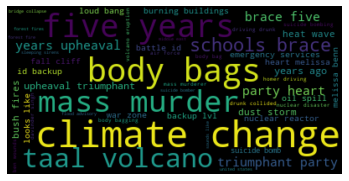

In [39]:
wordcloud_creator_bigram(text_negative)

### Most Similar Words for Real Event

In [40]:
vec_positive = data[data.target == 1]

In [41]:
tokenizer_vec_positive = RegexpTokenizer(r'[a-zA-Z]+')

vec_positive.text = vec_positive.text.apply(lambda x: tokenizer_vec_positive.tokenize(x))



In [42]:
vec_positive.text = vec_positive.text.apply(lambda x: remove_stops(x))

In [43]:
vec_positive_list = []

for sentence in vec_positive.text:
    vec_positive_list.append(sentence)

In [44]:
model_positive = gensim.models.Word2Vec(vec_positive_list, size=32)

In [45]:
model_positive.most_similar('ablaze')

[('role', 0.6744466423988342),
 ('influenza', 0.6660723090171814),
 ('iranian', 0.6520096063613892),
 ('olive', 0.6392245292663574),
 ('find', 0.6142639517784119),
 ('dead', 0.611478865146637),
 ('sydney', 0.5926734209060669),
 ('years', 0.5886222124099731),
 ('sector', 0.5876290202140808),
 ('dangerous', 0.5839536786079407)]

### Most Similar Words for Non Event-Related

In [46]:
vec_negative = data[data.target == 0]

In [47]:
tokenizer_vec_negative = RegexpTokenizer(r'[a-zA-Z]+')

vec_negative.text = vec_negative.text.apply(lambda x: tokenizer_vec_negative.tokenize(x))


In [48]:
vec_negative.text = vec_negative.text.apply(lambda x: remove_stops(x))


In [49]:
vec_negative_list = []

for sentence in vec_negative.text:
    vec_negative_list.append(sentence)

In [50]:
model_negative = gensim.models.Word2Vec(vec_negative_list, size=32)

In [51]:
model_negative.most_similar('ablaze')

[('allow', 0.9568873643875122),
 ('insurance', 0.9567834138870239),
 ('channel', 0.955030083656311),
 ('hands', 0.95469069480896),
 ('tippah', 0.9546656012535095),
 ('role', 0.9541995525360107),
 ('sign', 0.9540752172470093),
 ('wh', 0.9535608291625977),
 ('challenging', 0.9528957009315491),
 ('americans', 0.9524274468421936)]

# Feature engineering

### Lemmitization

In [52]:
from sklearn.metrics import f1_score

In [55]:
data_model = pd.read_csv('data/tweets.csv')

In [56]:
data_model.text

0        Communal violence in Bhainsa, Telangana. "Ston...
1        Telangana: Section 144 has been imposed in Bha...
2        Arsonist sets cars ablaze at dealership https:...
3        Arsonist sets cars ablaze at dealership https:...
4        "Lord Jesus, your love brings freedom and pard...
                               ...                        
11365    Media should have warned us well in advance. T...
11366    i feel directly attacked 💀 i consider moonbin ...
11367    i feel directly attacked 💀 i consider moonbin ...
11368    ok who remember "outcast" nd the "dora" au?? T...
11369       Jake Corway wrecked while running 14th at IRP.
Name: text, Length: 11370, dtype: object

In [57]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9!]+')

data_model.text = data_model.text.apply(lambda x: tokenizer.tokenize(x))

In [58]:
lemmatizer = WordNetLemmatizer() 

def lemm_text(words):
    lem = []
    for word in words:
        lem.append(lemmatizer.lemmatize(word))
    return lem  

In [59]:
data_model.text = data_model.text.apply(lambda x: lemm_text(x))

In [60]:
# Reformat to singular strings per observation
data_model.text = data_model.text.apply(lambda x: ','.join(x))
data_model.text = data_model.text.apply(lambda x: x.replace(',',' '))

###  Calculating TFIDF scores

In [61]:
X = data_model.text
Y = data_model.target
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [62]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'said', 'one', 'com','-', '–', '—', 'co', 'wa', 'ha', '1', 'amp']
sw_set = set(sw_list)

In [63]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X, Y, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer(ngram_range= (1,2), stop_words= sw_set)

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)


# Modeling 

Our data has a significant class imbalance, so just guessing that each case was a non event would be accurate 80% of the time. We need to find a model that can do significantly better than 80% accuracy and demonstrate through F1 score that it is able to do a good job of distingusing between the two classes. While its application relies on accuracy, F1 score is a better measure of future success when your data has a significant class imbalance as ours does.

### Baseline KNN

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
knn = KNeighborsClassifier(n_neighbors=1)

In [66]:
bl_model = knn.fit(tfidf_data_train_lem, y_train_lem)

In [67]:
bl_pred = bl_model.predict(tfidf_data_test_lem)

In [68]:
rf_acc_score_lem = accuracy_score(y_test_lem, bl_pred)
rf_f1_score_lem = f1_score(y_test_lem, bl_pred)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.8769

F1 Score: 0.5018


An out of the box knn is 87% accurate and does an okay job of picking between the two classes. I think more advanced models will work better however, especially in terms of F1 score.

## Random Forest Classifier with TFIDF Scores

First lets try a Random Forest Classifier (RFC) with our engineered TFIDF scores

In [69]:
from sklearn.metrics import f1_score

In [70]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0, class_weight= 'balanced')

In [71]:
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [72]:
rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.887

F1 Score: 0.5666


An RCF classifier did significantly better than our baseline, bumping the accuracy up to .889 and achieving and F1 score of .566. Lets still check if a Naive Bayes Classifier does any better then tune whichecver one works the best. 

## Naive Bayes

Lets try a Naive Bayes model with our TDIF scores and see if we can get even better results.

In [73]:
from sklearn.naive_bayes import MultinomialNB

In [74]:
nb_classifier = MultinomialNB(alpha = .01)

In [75]:
nb_classifier.fit(tfidf_data_train_lem, y_train_lem)
nb_test_preds_lem = nb_classifier.predict(tfidf_data_test_lem)


In [76]:
nb_acc_score_lem = accuracy_score(y_test_lem, nb_test_preds_lem)
nb_f1_score_lem = f1_score(y_test_lem, nb_test_preds_lem)

In [77]:
print('Naive Bayes with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(nb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(nb_f1_score_lem))

Naive Bayes with Lemmatization Features
Testing Accuracy: 0.898

F1 Score: 0.6813


The NB classifier did great! It got our accuracy up to almost .9 which is only slightly better than the baseline .87 but it also has an F1 score of .68 indicating it is pretty good at actually differntiating between the two classes. 

### Hyperparameter Tuning

In [78]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0 ], 'fit_prior' : [True, False]
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, scoring= 'f1', verbose=5,)
multinomial_nb_grid.fit(tfidf_data_train_lem, y_train_lem)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.2s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0],
                         'fit_prior': [True, False]},
             scoring='f1', verbose=5)

In [79]:
multinomial_nb_grid.best_params_

{'alpha': 1.0, 'fit_prior': False}

In [80]:
grid_preds = multinomial_nb_grid.predict(tfidf_data_test_lem)

In [81]:
nb_acc_score_lem = accuracy_score(y_test_lem, grid_preds)
nb_f1_score_lem = f1_score(y_test_lem, grid_preds)

In [82]:
print('Naive Bayes with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(nb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(nb_f1_score_lem))

Naive Bayes with Lemmatization Features
Testing Accuracy: 0.8918

F1 Score: 0.6132


### Additional Cross Validation 

I am not sure why the non grid search model seemed to perform far better, lets try some further cross validation to see if it can help us understand whats happening here. 

In [83]:
from sklearn.model_selection import cross_val_score
all_accuracies_non_grid = cross_val_score(estimator= nb_classifier, X= tfidf_data_train_lem, y= y_train_lem, cv=10)

In [84]:
from sklearn.model_selection import cross_val_score
all_accuracies_best = cross_val_score(estimator= multinomial_nb_grid, X= tfidf_data_train_lem, y= y_train_lem, cv=10)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.0s finished


In [85]:
print(f"without grid search:", {np.mean(all_accuracies_non_grid)},
       f"with grid search:", {np.mean(all_accuracies_best)})

without grid search: {0.6352254016610452} with grid search: {0.5788487230652274}


I am not sure whats going on here but lets stick with an alpha of 0.01 since that seems to work best for our model even after cross validation, regardless of what the grid search indicated. 


### Finalizing our Model by Training it on all the Tweets 

In [86]:
tfidf_all = TfidfVectorizer(ngram_range= (1,2), stop_words= sw_set)

X_all = tfidf_all.fit_transform(X)


In [87]:
nb_all = MultinomialNB(alpha = .01)

In [88]:
nb_all.fit(X_all, Y)

MultinomialNB(alpha=0.01)

In [89]:
all_preds = nb_all.predict(X_all)

In [90]:
nb_acc_score_all = accuracy_score(Y, all_preds)
nb_f1_score_all = f1_score(Y, all_preds)

In [91]:
print('Naive Bayes with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(nb_acc_score_all))
print()
print("F1 Score: {:.4}".format(nb_f1_score_all))

Naive Bayes with Lemmatization Features
Testing Accuracy: 0.997

F1 Score: 0.992


### Most Important Features 

In [113]:
feature_names = tfidf_all.get_feature_names()
top10 = np.argsort(nb_all.coef_[0])[-10:]

print(" ".join(feature_names[j] for j in top10))

australia storm volcano iran thunderstorm train killed people fire http


**The most importand words in the Multinomial Naive Bayes Classifier model are:** 
1. australia
2. storm
3. volcano 
4. iran
5. thunderstorm 
6. train 
7. killed
8. people
9. fire
10. http

## Further Validation

Lets see if we can validate the results of our model further by getting some new data and testing it. We downloaded 100 tweets using the top 5 key terms for the real and non real cases from our eda to test our models ability to differentiate between the two classes in the most common circumstances. We manually tagged each of the 100 tweets using the same methodology as the original dataset. We manually tagged them as an even or non event using the same methodology as our original data set. Lets see how our model does on totally different tweets from our train and test set.

In [95]:
data_new = pd.read_csv("data/further_validation_tweets_target.csv")

In [96]:
data_new.head()

,Unnamed: 0,tweets,target
0,0,RT @dammie_remix: The only breathe taking expe...,0.0
1,1,@waddie146 @JudicialWatch @realDonaldTrump @To...,0.0
2,2,Now you can drop the mother f****** mic behind...,0.0
3,3,RT @dammie_remix: The only breathe taking expe...,0.0
4,4,Your Ex is drowning 😁\nUse an emoji to describ...,0.0


In [97]:
data_new.drop('Unnamed: 0', axis = 1, inplace=True)

In [98]:
data_new.head()

,tweets,target
0,RT @dammie_remix: The only breathe taking expe...,0.0
1,@waddie146 @JudicialWatch @realDonaldTrump @To...,0.0
2,Now you can drop the mother f****** mic behind...,0.0
3,RT @dammie_remix: The only breathe taking expe...,0.0
4,Your Ex is drowning 😁\nUse an emoji to describ...,0.0


In [99]:
data_new.isna().sum()

tweets    0
target    1
dtype: int64

In [100]:
data_new.dropna(inplace= True)

In [101]:
data_new.target = data_new.target.apply(lambda x: int(x))

In [102]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9!]+')

data_new.tweets = data_new.tweets.apply(lambda x: tokenizer.tokenize(x))

In [103]:
lemmatizer = WordNetLemmatizer() 

def lemm_text(words):
    lem = []
    for word in words:
        lem.append(lemmatizer.lemmatize(word))
    return lem  

In [104]:
data_new.tweets = data_new.tweets.apply(lambda x: lemm_text(x))

In [105]:
# Reformat to singular strings per observation
data_new.tweets = data_new.tweets.apply(lambda x: ','.join(x))
data_new.tweets = data_new.tweets.apply(lambda x: x.replace(',',' '))

In [106]:
X_new = data_new.tweets
Y_new = data_new.target


In [107]:

tfidf_new = tfidf_all.transform(X_new)


In [108]:
grid_preds = nb_all.predict(tfidf_new)

In [109]:
nb_acc_score_lem = accuracy_score(Y_new, grid_preds)
nb_f1_score_lem = f1_score(Y_new, grid_preds)

In [110]:
print('Naive Bayes with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(nb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(nb_f1_score_lem))

Naive Bayes with Lemmatization Features
Testing Accuracy: 0.9184

F1 Score: 0.75


Our model did pretty great on our holdout set; this could be becuase we used the most common keywords for each class but it is our reccomendation that in applying this model the top keywords would also be used.

# Analysis and Application

## How did our models do?

Our best model was the multinomial naive bayes classifier which got a cross validated F1 score around .68 and an accuracy score consistently over .88. This means that our model was about 9% more accurate than guessing the dominant class and had a reasonable ability to distinguish between the two classes. From our baseline KNN model we raised our accuracy by around .03 and our F1 score by .18. From this we can say it would be a useful model to further narrow your search when trying to determine between events and non events, but not the end of the process. 

## Recommendations

We would reccomend our model for any news or other orginization who wants to use the twitter API to look for events. By using the keyword search terms we found were most likely to be a real event: **violent storm, derailed, chemical emergency, hazardous, buildings on fire, body bag, sinkhole, derailment, collision and thunderstorm,** in conjunction with our model, news orginazations will be able to find a much smaller subset of tweets they can then manually analyze and investigate further

## Next Steps

### More Data
- 11,000 is not a small data set but NLP learning always does better with more entries to learn from. This dataset could easily be 100,000 tweets

### Use Pretrained Vectors
- We wanted to implement some pretrained vectors with GLoVe from Standford but unfortunately there model is seemingly facing some legal trouble right now. Their vectors were trained by billions of tweets.
- We expiremented with Word to Vec but the vectors learned from our data set did not improve any of our models. This code was messy and not in the final notebook. 

### Neural Net?
- A nueral net did not seem worth additional effort with our data set, but if we scraped more tweets and got a sufficiently large data set it could provide more classification power. 